#### To run the pretrained model. Scroll down to "Generate Text" Section at the bottom

Most of this code taken from https://colab.research.google.com/drive/13dZVYEOMhXhkXWfvSMVM1TTtUDrT6Aeh?usp=sharing#scrollTo=NKGBoVwuhM4H

What I added:
- Special tokens for each meditation type.

# GPT-2 Fine-Tuning Tutorial with PyTorch & Huggingface in Colab




This is a simplified script for fine-tuning GPT2 using Hugging Face's [Transformers library](https://huggingface.co/transformers/) and PyTorch.

You should understand the basics of PyTorch and how a training loop works before getting started. [This official PyTorch tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html) serves as an excellent introduction. Familiarity with the workings of GPT2 might be useful but isn't required. The code has been written for clarity and not re-use. I'd advise refactoring it for actual projects. I've liberally taken bits from [Chris McCormick's BERT fine-tuning tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/), [Ian Porter's GPT2 tutorial](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html) and the [Hugging Face Language model fine-tuning script](https://huggingface.co/transformers/v2.0.0/examples.html#language-model-fine-tuning) so full credit to them. Chris' code has pretty much provided the basis for this script - you should definitely check out his [blog](https://mccormickml.com/tutorials/).

I should mention what the script doesn't cover:

- Using the [nlp](https://huggingface.co/nlp/) library to load in the dataset and setting up the training workflow, which looks to streamline things rather nicely.
- [Accumulated gradients](https://medium.com/huggingface/training-larger-batches-practical-tips-on-1-gpu-multi-gpu-distributed-setups-ec88c3e51255) - this gives larger effective batch sizes than Colab allows (GPT2 is a large model, and anything more than a batch size of 2 would be enough to get a CUDA out of memory error on Colab).
- [Freezing layers](https://github.com/huggingface/transformers/issues/1431). This is the process of only changing the parameters in selected layers, made famous by the [ULMFit](https://arxiv.org/abs/1801.06146) process.
- [Using 'past'](https://huggingface.co/transformers/quickstart.html#using-the-past) when generating text. This takes in the previous state when generating successive items of text. I didn't need it.
- [Tensor packing](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html). This is a neat way of fitting in as much training data in each batch.
- [Hyperparameter search](https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10). I settled quickly on values that seemed to produce decent values, without checking if they were optimal.

# Setup

In [ ]:
!pip install transformers

In [2]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
# % matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
%matplotlib inline

In [ ]:
!nvidia-smi

# Create Training Set

The data used to finetune the language model is a set of around 1000 DJ biographies, with the aim of generating them in the same general format and style.

This data isn't public so if you want to use this script, you'll have to source your own training set.

In [7]:
# mount my Google Drive directory and access the training data located there
gdrive_dir = '/content/gdrive/'
data_dir = os.path.join(gdrive_dir, "'My Drive'","'Cross Labs'","'Text Gen Models'")
filename = 'yt-transcripts-data-cleaned.csv'

drive.mount(gdrive_dir, force_remount=True)


In [ ]:
# copy the data to the current Colab working directory
# !cp $data_dir/$filename .

In [ ]:
# load into a data frame
df = pd.read_csv (filename)
df.dropna(inplace=True) #  remove NA values
print(df)

     Meditation_Type                                                URL  \
0            focused  https://www.youtube.com/watch?v=IReEu2kI6oI&li...   
1            focused  https://www.youtube.com/watch?v=O-6f5wQXSu8&li...   
2            focused  https://www.youtube.com/watch?v=inpok4MKVLM&li...   
3            focused  https://www.youtube.com/watch?v=itZMM5gCboo&li...   
4            focused  https://www.youtube.com/watch?v=U9YKY7fdwyg&li...   
...              ...                                                ...   
4885        movement  https://www.youtube.com/watch?v=4t45O953P80&li...   
4886        movement  https://www.youtube.com/watch?v=PUZfdigPVQU&li...   
4887        movement  https://www.youtube.com/watch?v=zNxjX3ueNa0&li...   
4888        movement  https://www.youtube.com/watch?v=QKyWaHKeGgY&li...   
4889        movement  https://www.youtube.com/watch?v=d5C02fPg7-Y&li...   

                                                 Script  
0     so sitting comfortably just beginni

In [ ]:
scripts = df.Script.copy()
scripts

0       so sitting comfortably just beginning with a n...
1       hey there and welcome to this meditation to he...
2        hey there and thanks for gifting yourself the...
3       hi and welcome to this meditation for self-lov...
4       hi and welcome to this meditation for beginner...
                              ...                        
4885    oh let there be peace among all beings of the ...
4886    oh to begin with you have to find out who is t...
4887    oh my baby peace let them peace so Shanti Shan...
4888    oh oh let there be peace and love among all be...
4889    foreign who is this who who's looking yes I am...
Name: Script, Length: 4890, dtype: object

We need to get an idea of how long our training documents are.

I'm not going to use the same tokenizer as the GPT2 one, which is a [byte pair encoding tokenizer](https://blog.floydhub.com/tokenization-nlp/). Instead, I'm using a simple one just to get a rough understanding.

<ipython-input-7-922b22274dc6>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doc_lengths)


<Axes: ylabel='Density'>

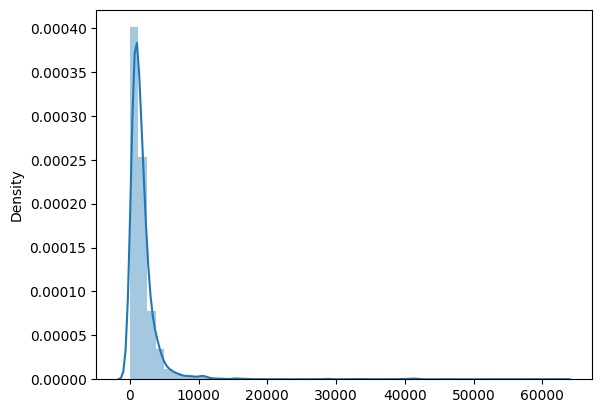

In [ ]:
doc_lengths = []

for script in scripts:

    # get rough token count distribution
    tokens = nltk.word_tokenize(script)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [ ]:
# the max token length
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.714519427402863

In [ ]:
np.average(doc_lengths)

1868.8443762781187

Even though these token counts won't match up to the BPE tokenizer's, I'm confident that most bios will be fit under the 768 embedding size limit for the small GPT2 model.

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens.

In [ ]:
SPECIAL_TOKENS = [
    '[FOCUSED MEDITATION]',
    '[BODY-SCAN MEDITATION]',
    '[VISUALIZATION MEDITATION]',
    '[REFLECTION MEDITATION]',
    '[MOVEMENT MEDITATION]'
]

# # You can link tokens to special vocabulary when instantiating
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", unk_token="<unk>")
# # You should be sure '<unk>' is in the vocabulary when doing that.
# # Otherwise use tokenizer.add_special_tokens({'unk_token': '<unk>'}) instead)
# assert tokenizer.unk_token == "<unk>"

In [ ]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

# ADDED SPECIAL TOKENS
# tokenizer.add_tokens(SPECIAL_TOKENS)
new_tokens_added = tokenizer.add_special_tokens({'additional_special_tokens': SPECIAL_TOKENS})
                                                                # ^ SPECIAL_TOKENS is a list
print('new_tokens_added', new_tokens_added)
print('new tokens ', tokenizer.additional_special_tokens)
# ADDED new config to set
configuration = GPT2Config(vocab_size=len(tokenizer)).from_pretrained('gpt2')
print('len tokenizer', len(tokenizer))
# configuration.vocab_size = len(tokenizer)  # UNCOMMENT
print(tokenizer.all_special_tokens)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


new_tokens_added 5
new tokens  ['[FOCUSED MEDITATION]', '[BODY-SCAN MEDITATION]', '[VISUALIZATION MEDITATION]', '[REFLECTION MEDITATION]', '[MOVEMENT MEDITATION]']
len tokenizer 50264


In [ ]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [ ]:
batch_size = 2

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [ ]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each bio in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the bio is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens.

If the bio is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [ ]:
dataset = GPT2Dataset(scripts, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

4,401 training samples
  489 validation samples


In [ ]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [ ]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.  # UNCOMMENT FOR CUDA
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50264. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


In [ ]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [ ]:
# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(  b_input_ids,
                          labels=b_labels,
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,
                                    top_k=50,
                                    max_length = 200,
                                    top_p=0.95,
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
#                            token_type_ids=None,
                             attention_mask = b_masks,
                            labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,201. Loss: 1.835741639137268.   Elapsed: 0:00:47.
0:  bipartisan, state and federal. So far they may be able to find the most reliable and reliable guide to the challenges of today's life. And yes please do not feel afraid of me. And yes feel confident in myself. So now we may have a life together I'll be able to be confident of my ability and strength so let it flow freely I'll take full control of my destiny and make my destiny more peacefulI will allow I will be safe and secure in my life and in my body I'll allow you to choose my destiny and let it flow freely I'll create a life together. I will allow you to choose my destiny and make my life more peaceful and confident and secure in my life I'll choose my life and the life of each of you. I will choose my life now, I'll choose my life now before I and the life of each of you. I will choose my choice to choose my life now I am happy to be happy and safe and comfortable in


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,201. Loss: 3.652031183242798.   Elapsed: 0:01:39.
0:  increasing my body and spirit the scent of grass and my voice and my sense of smell and my voice and my voice and my breathing. I am the only person with a voice. I love this voice and what it means. Whether I'm alone or the whole world around us. I love to do it right and it means so much to me that I want to help as much as possible. I want to be the best person I can ever be. I want to be my biggest source of joy and happiness. And if you have any concerns about this particular thing maybe don't worry so much. This is absolutely not my intention. I can definitely handle myself and my health. And we may also need a break now. But I don and I'm sure you're looking for this because I have to be so completely honest you can't get enough of your own stuff. It's the most important part of your life. There's no way I can help you or give you some help.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,201. Loss: 2.9064853191375732.   Elapsed: 0:02:29.
0: day we invite you to enjoy a wonderful new adventure for yourself by joining us today as we celebrate our holiday we'll be talking about our current holiday season and share some fun things to do while enjoying this moment with us while we look forward to the season ahead we'll be meeting up with the author of the holiday books and one of our favorite books is this one but we'll also be talking about getting ready for the season ahead it's easy so just grab your clothes and start preparing yourself for the year ahead so we'll be talking about how we are preparing our winter jackets to be worn and how we are showing our big screen shows off this summer we are making sure that all of our jackets are they've got all a bit more modern jackets we have a lot more antique jackets our jackets are the ones you have to wear to be successful but they're not old enough to work in winters the ones you have to wear the ones w

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,201. Loss: 2.297020435333252.   Elapsed: 0:03:22.
0:  Hangthe most beautiful night's morning in this beautiful place in the middle of nowhere is the best morning's day is the best morning's morning's day you might go with this perfect morning's meditation and just relax your heart may you just be in the present moment maybe you think that you know the answer to all this but you're not going to know the answer because the best day is the best day for you this is a very deep breath in and out breathing in and out breathing in and out breathing in and out breathing in and out breathing in and out breathing in and out breathing in and out breathing in and out breathing in and out breathing in and out breathing in and breathing in and out breathing in and breathing in and it's okay breathing in and out breathing in and out breathing in and breathe breathing in and you'll feel so much happier even more comfortable today breathe in and out breathing in and breathe breathi

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,201. Loss: 2.772321939468384.   Elapsed: 0:04:14.
0:  foods to help you relax and relax into the rhythm of this guided meditation as you are ready simply take a seat on the floor or lie down on your back and release that tension relax a bit letting go of your shoulders feel yourself settling into a relaxed natural rhythm take in a deep breath in through your nose and out through your nose in through your mouth noticing the sensations as well as your breath allowing your hands to be slightly relaxed take in a beautiful deep breath out with a little bit of effort so that you are just beginning to fully relax let go of any tension your arms will let go of feel the breath naturally and with your awareness your chest and shoulders are letting go of any tension let your gaze move to your eyes take a deep breath in at your temples notice the natural rhythm of your breath as you exhale and out let go of any tension in your body let go of any tension tension that can be pla

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,201. Loss: 3.034137010574341.   Elapsed: 0:05:07.
0:  trail we ventured our way across this vast expanse of bliss to uncovering each and every part of the vast temple and hall of the temple of infinite wisdom that exists on this planet we ventured deep into the inner depths of this world and explored the universe to find our true purpose of being this place where knowledge and insight lies and where knowledge and insight reside and what it means to be divine beyond compare these very depths and what we see at the top of the magnificent temple of infinite wisdom will you find profound and profound insights that take you into the world to discover more about yourself find it easy to follow these instructions and take your time to discover more about this vast temple as we set out on this journey our journey will take us from the inner world to infinity we will meet this grand temple on a journey of discovery and profound experiences and what we find will open up new 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,201. Loss: 2.402247428894043.   Elapsed: 0:05:59.
0: intend of the whole meditation with the mind you are always working to connect with your inner self and others of all faiths so that we may deepen our connection with them today let's begin by going through the three main categories of consciousness. There you see an image of the heart or the eye of the observer, or the brain or the heart. You see it in your mind today I will start with the mind and the mind will be able to hear what is said to it by a word spoken by a human being and then you will find yourself with the mind and the mind will open up for the eyes as you hear these words in the mind will let the mind hear them in the eyes now let's begin with the body. The mind and the body will be able to sense anything what you hear so let's begin with the heart. The heart will sense the physical body and then we will also need an eye to see the eyes. The eye will be able to feel things and then it is


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,201. Loss: 3.223045825958252.   Elapsed: 0:06:53.
0:  surround this meditation we will walk through how to manifest your inner beauty and manifest the inner peace you've all been waiting for today we will continue on our journey together with a few words of healing and peace as we begin today if you have a deep seated inhale allow yourself to sink deeper into the earth breathe in and out of this space relax and let your eyes close to soften with a smile when you've finished breathing in you will release all tension the energy that has been stored within your body releasing a few more negative thoughts if you feel distracted during this meditation if you are interrupted by thoughts of guilt or guilt-filled feeling-good thoughts take a deep breath in and out as you listen to this meditation you will emerge from this journey one step closer to your beautiful inner light your beauty and you will transform into a beautiful being for your day namaste and namaste namaste 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,201. Loss: 1.5914403200149536.   Elapsed: 0:07:47.
0:  reflex and a bit of tinkling sound which makes all the tabletop games around it quite a little bit funnier and more refreshing if you haven't seen it yet so you know a lot about how this game works so in particular the introduction to the video that we did before the introduction of the game we had two really good videos so one of our videos that we had from the beginning that is called the The Dawn of Ages for a really boring and boring game that we did during the course of the video was called Dawn of Ages and it's a game that we did so much really fun for so many reasons it was so much fun and really frustrating like being in a bunch of castles and not being able to really go in that way because there's so many castles that you have to be in anyway because there's so many castles and stuff but there's a real difference between the end of your game and when you do that you want to have some sort of fun that y

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,201. Loss: 2.8439269065856934.   Elapsed: 0:08:39.
0:  display this video will focus on taking the practice of yoga with you to a new dimension of comfort and abundance you can reach into your pockets or purse and make sure that you are completely supported on all your next breath cycle and breathe completely through your nose and the back of your head for the whole duration of your breath this practice will be done seated or reclined lying in a chair or bed or a chair on a quiet forest floor or a bench in your bed take a deep breath into your nose fill with air with a sense of peace inhale slowly inhale slowly let the breath go you're ready for yoga this is your chance to become an integral part of your yoga routine with this video description we recommend that you begin by finding a comfortable seated position either lying down or sitting up if you prefer this position it is okay to lie down if you are in a position where you cannot reach your hands reach to your

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,201. Loss: 2.4379310607910156.   Elapsed: 0:09:32.
0:  pastor it is my honor to be here today with you today when you are ready my heart is aligned with you so take a moment to relax your body and your mind as you continue to settle in take a moment to let your mind drift and your mind settle back into your day I am here today thank you to have such a wonderful day today my name is Sara Raymond I am grateful for all my family and friends today we are going to begin by preparing you for the upcoming fall equinox your body and mind will be completely prepared for this time of winter your spirit will be awakened you may even have a new color to see in your mind when your mind wanders to winter just use the words to let your spirit drift and your mind focus on the upcoming fall season you may ask your heart to open its heart for you as you prepare for your fall equinox welcome to this practice you will receive this video by going to a place where you can sign up now yo

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,201. Loss: 3.6600775718688965.   Elapsed: 0:10:25.
0:  illicitlet's make some coffee as you drift off towards the house I'm gonna take a deep breath in and take it out if you have to put a little more strain on your back just to make the process a little bit easier I'm gonna start by making sure that you're lying in a nice nice comfortable position so that we're in a very comfortable position you can sit in any sort of chair there's no props to be found we're all right here if it feels good to you it could be lying down on your back if you're sitting on your knees or you can sit back on a chair but the most comfortable position is not the most comfortable posture so there's still some tension you're sitting on your knees you might imagine that you're sitting on your thighs so just imagine that you're looking down towards the ceiling and as you look down towards the room you're looking down towards your feet and you look back up towards the ceiling and it's a warm u

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,201. Loss: 3.4057188034057617.   Elapsed: 0:11:18.
0:  Liberation I am going to leave you there with a sense of peace I believe that you can be proud and powerful as you go about your day it is my purpose to help you let go of any old worry in your mind and to find peace now this journey is about creating a positive energy where you can release stress you can be strong and energized you can be centered and healthy you can have a joyful and healthy family life and you can have the ability to move forward it is your honor to be here with me this will be a guided meditation and if you do not already have a comfortable seat the instructions are in the description box below I would love you to go ahead and make yourself comfortable close your eyes or relax and let the sound of my voice guide you down you may wish to make yourself very relaxed take a moment to just notice where your body is and what the outside world is like and just find a position where you feel comfor

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,201. Loss: 3.215386390686035.   Elapsed: 0:12:11.
0:  Nam we are here to share our deepest joy today our journey we are going to dive deeper into the body to cultivate a body that is comfortable yet calm the body needs to be able to heal you as you heal what's needed in this moment is a sense of love you can connect with the feeling around you and when you connect with your sense of body you start to be able to heal and let go of negative thoughts your whole being you start to heal yourself more slowly allowing yourself to be in a moment that you have felt ready for so many healing opportunities you begin to heal and let go of that negative energy around you beginning to heal more you can start to feel love in your body feeling love for yourself and trusting yourself for who you truly are thank you for showing up so soon with a smile on your face and the sense of trusting and letting go thank you so much for joining me today I hope you enjoy this experience enjoy t

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,201. Loss: 2.4705803394317627.   Elapsed: 0:13:04.
0: ION of The Heart Association 1:6 Minute Guided Meditation to Relax and Enjoy an Exquisite Relaxation 3: Relax your Relaxation Relax Relax your Relaxing your Relaxing your Relaxing the Relaxing your Relaxing you Relax your Relaxing the Relaxing Relaxing your Relaxing your Relaxing the Relaxing the Relaxing Relaxing the Relaxing relaxing your Relaxing your Relaxing your Relaxing yourself you relaxing yourself you relaxing your Relaxing your Relaxing your Relaxing yourself relaxing your Relaxing yourself relaxing your Relaxing yourself relaxing your Relaxing yourself relaxing relaxing your Relaxing yourself relaxing your Relaxing yourself relaxing your Relaxing yourself relaxing your Relaxing yourself relaxing and now slowly closing your eyes bring your attention up to your chest and your neck let your attention go of the weight of the chair or cushion and the chair or cushion where your chair or cushion meets the 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,201. Loss: 3.0284950733184814.   Elapsed: 0:13:57.
0:  glimpse in this video you're going to learn how to use the camera lens properly, so it's time to go ahead and get settled in you can take one last big breath in and out and when you do so you'll have a good vantage point and you're just going to be just sitting there and just watching the environment around you it doesn't matter it doesn't matter that you don't have the time for yourself at all you just are this so in this video this little kid got out of class and he was learning to shoot the lens okay so this kid was really learning a new thing how to use the lens and so in this video we are going to start and start to move into the body okay but the first thing we're going to do is we're going to start to wire into the body and begin to wire into the bones of the body and what this is is called a spinal cord so a cord so this is the spine it's the line that runs around the spine and the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,201. Loss: 2.3209733963012695.   Elapsed: 0:14:52.
0:  Laure of THE Snares of Brahma Kumaris. Last month's lecture has been given to us by the head of the Snares of Brahma Kumaris. On a journey into unchanging truth and death it is said, 'The only one who knows the truth is that he who does not possess it will die.' On one such journey it is said, 'The way to live is to travel by way of life.' On another journey by way of death it is said, 'The way to live is to die.' 'How shall we go to death? By way of life.' Sri A. Dharani. This is a time of being for those who desire to be guided by this truth in life in order to understand the truth and attain it. This is a time for those who desire to achieve it by way of life because there is a constant and constant need for any thought that no longer serves or is directed by a mind or by the soul of a being


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,201. Loss: 3.0348761081695557.   Elapsed: 0:15:44.
0: ismso much more positive and much more fun than what you can imagine the good news about this meditation is that you can have the time to do just that so you don't have to use your imagination to understand what you're feeling and your feelings as we move through this meditation I want to share a little bit of research I have done on meditation for addiction but I am also passionate about this topic because research on addiction is often elusive and elusive it is becoming easier and easier to understand the relationship between how we experience addiction and how we work with it so I want to give you a sense of how this meditation practice really works and how the results work it works as we move into the familiar state of meditation practice so I want you to make sure that you are ready to settle into comfort so that you can easily return to the sensations of the breath on your next breath out and then as you e

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,201. Loss: 3.038635015487671.   Elapsed: 0:16:38.
0: oun I know you're worried about me but please don't be afraid to ask yourself why you're here the purpose of this meditation is to help you let go of all stress worries so take a few moments to get comfortable lying down for this very end of this meditation and just enjoy the music the music just so you can just just chill out and just enjoy and just relax and allow yourself to just fall asleep to this beautiful music that's all around you just gently bringing your awareness to your breathing and just letting go of any stress and any tension with a little deep breath letting go of any thoughts of letting go that are just that you can just be and to give yourself permission to fully let go allow yourself to just let go of your expectations you just let go of all worries and expectations of how you feel your mind is a great vessel for this and so as you inhale breathe in love and love and then out let out all of th

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,201. Loss: 2.9003944396972656.   Elapsed: 0:17:31.
0:  election your next five minutes your best wishes are your own and I would like you to continue to lie down so that you can enjoy the next few minutes with us breathe in through your nose and feel yourself settling into a comfortable position or on the other side feel yourself reaching for the heavens to comfort you so that you can be comfortable as you continue breathing you can open your eyes for a few moments and now begin to settle into your body as you focus on the breath this allows your body to let go completely through your body your muscles relaxing and relaxing every last cell in your body now focus on your breathing to focus on the gentle rising in your chest you can imagine as you exhale slowly begin to feel the breath entering from all places of the body there are a few moments between the breathing you notice any places of discomfort and relaxation you may find that when you let go of any tension i

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,201. Loss: 2.106618881225586.   Elapsed: 0:18:24.
0:  crazy or alternatively this is the case with a guided meditation I will give you a guided meditation for finding a comfortable place to sit lie down or lie down with the open heart or close your eyes and soften the gaze and bring awareness to the physical body with your eyes closed and eyes open simply come into stillness without changing anything in your physical experience without trying to change or change anything on your inner or outer experience without looking back or having an objective view of the world without looking back or seeing past anything there is a higher force greater than us all of life has the capacity to take us back to a higher place and this higher force is called the universe in this very moment so I will give you a guided meditation to discover this higher power from within now begin to let go of past distractions and become still with your eyes closed and open as you open and notice t

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  2,201. Loss: 2.632154941558838.   Elapsed: 0:19:17.
0:  benchin this meditation we will be going through different parts of the mind the mind that wants to think, the mind that wants to act and the mind that wants to stay awake and focus on what is right and what is wrong and you should keep trying to go through different parts of your mind that are trying to keep the present moment going and in order for this meditation to work best you need to go through a series of thoughts in a very quiet way to keep the mind quiet and alert so as you concentrate on one thing the mind will stay in your mind and in this meditation everything will be relaxed and as you get more relaxed you're more likely to focus on something other than your body you should go back to the first thing that you focus on for about four to seven years until you realize that nothing is happening at the moment it will be just like this let go of any effort or stress any tension or resistance and instead 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,201. Loss: 2.1407370567321777.   Elapsed: 0:00:50.
0:  incorporated the practice of mindfulness can be helpful when dealing with difficult emotions that arise in life and it can lead to unnecessary stress as well as unhealthy behaviors such as overeating and alcohol consumption this systematic approach is particularly useful when mindfulness is in a state of flux and it may not provide realistic solutions for difficult emotions that arise this practice is not a substitute for medical treatment and it is not a substitute for mental health care when mindfulness can offer new and medical applications for mindfulness in the treatment of difficult emotions this systematic approach will guide you into an easy and effective practice of mindfulness as you focus on the present moment as you move into a relaxed state you can begin to experience a powerful sense of peace with acceptance and acceptance of what is true for you in this practice there is a continuous dialogue bet

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,201. Loss: 2.7255184650421143.   Elapsed: 0:01:44.
0: PeterA meditation to make you feel calm and relaxed when you listen to this meditation find a comfortable place where you will not be disturbed it will take you nowhere fast or heavy but you will also be able to listen to my voice now while you listen I will guide you in a guided meditation to make you feel calm and relaxed just listen carefully to the sound you hear you may hear the sound of my voice as it relates to your internal voice this will only make you feel slower and more comfortable with the time being listened closely by you now I will guide you to move towards the wall that is the wall of the meditation but keep in mind this is the point you are sitting on when I count you up I will guide you to the wall nearest you move down into the wall to the left a few times stepping away from the wall to the right now as you are moving down it I want you to be curious about your physical state take a moment to

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,201. Loss: 2.8607988357543945.   Elapsed: 0:02:38.
0: uring- Alright everyone let's get started take a few moments to settle into your position so your body and your mind are in a nice position to start this practice so let's begin we'll start first by getting into a comfortable seated position just lying down taking a few nice deep breaths we'll take a few deep breaths in through our nose for those feeling low and low they've probably been feeling really low so I don't have that much of a headache in this practice at all let's just continue to notice how we're feeling so what is it we're feeling right now and then breathe into your body right now you might be feeling that you're feeling tingling or vibration maybe tingling or a buzzing or just a little bit of a sensation of any type maybe a sensation of maybe your eyes or your nose maybe an itch or some other type of sensation whatever it is so I know you're feeling it but I just want you to remember you're feelin

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,201. Loss: 2.800297737121582.   Elapsed: 0:03:31.
0:  reproductivehello my name is Sara Raymond and welcome to this guided meditation as you continue with your day's events I will guide you through a number of short meditations or even a meditation that will be beneficial to you if you feel you are lacking energy within your daily routine you might decide to listen to the playlist or listen to this meditation as your own and as you focus more on this meditation you can listen to your inner voice as an anchor to help you release any limiting beliefs or ideas that have been holding you back for the last several weeks I will guide you through a number of short meditations that will help you focus more and more and I will guide you to do so with the intention to inspire you to feel inspired continue to listen and connect with yourself in this way knowing that you have the resources and the willingness to take action that will make for a happier fuller and fuller life l

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,201. Loss: 1.939673662185669.   Elapsed: 0:04:23.
0:  zoneI am sorry for that. Just for the love of my life this is my first time on this channel. I wanted to share this with you. So, it doesn't matter how long this journey goes on. It is about giving this body a really loving and loving energy for life and the universe. I want to give it your full attention, your body and if it hurts, you can let it go. Just let it go. So, we're going to start by finding the space. And the place. And I want you to create a space to feel safe, feel comfortable and to feel loved. And that is the first thing we're going to do with you. So close your eyes. And settle, relax. Now that you're in your natural comfortable seated position. I want you to take a nice filling breath into your nose, feel your belly rise and fall in sync with that belly rise and fall in sync with that belly. And breathe in deeply and breathe out through


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,201. Loss: 2.4852476119995117.   Elapsed: 0:05:16.
0:  commits welcome to this guided meditation for chronic anxiety reduction please listen to this recording on your first or second listen to the breathing to find ease and inner peace with each exhale to start your day intentionally and listen to the messages of your mind to help you deal with anxiety when this happens we often start with thoughts and react when these negative thoughts act as mental triggers for anxiety to come in and be released by our minds we don't need to stay in the mental chatter we will start with relaxation and release this guided meditation with a few simple affirmations as you sit comfortably take a deep inhale into your nose and an even deeper exhale into your mouth allowing the natural flow of air through the nostrils to create a sense of spaciousness and openness you are an alpha brainwaveleader and can use whatever means best for you as you listen take a moment to gather your awarene

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,201. Loss: 3.345580577850342.   Elapsed: 0:06:09.
0:  irony you hello thank you for tuning in I hope you have a wonderful day thank you so much for joining me today I have a great deal of content that you would like to share with the world today so I hope you'll be seeing that a lot of you have already signed up for the channel today I know that you are definitely considering joining this channel and I'm hoping that you've done your best and I know you may be holding out a lot of some stuff but as always just make sure that all notifications are switched off if your notifications are just go ahead and do your best so that we're all set for tomorrow where we get to know our team and hopefully know when to roll out the rest of our tools for today's work so let's get on the ground floor I think it's a pretty simple channel for you to learn some new skills and learn some new ideas of what it would do if you were to start it as a part of a larger group of people this is

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,201. Loss: 3.5517542362213135.   Elapsed: 0:07:03.
0:  Sahso this is dr john verhey from the mindful movement a practicing qigong meditation if you've never meditated before or even if you've never meditated outside of the classroom this is the perfect meditation especially if you're practicing this qigong for you can do this anytime you like or you may even do it with your bare hands on your belly just kidding you can do this anywhere that you like do this practice as if you are sitting in the sun in a hammock on the ground you can also do this whenever you like perhaps on the floor under a big tree in nature as we move through this process feel free to place your palms down wherever feels good and begin to breathe in fully and breathe out slowly with each in and out inhale and exhale do this one three more times inhale and breathe out let your body settle and breathe a little more deeply so that you can release the belly from all the belly and release all the str

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,201. Loss: 2.324333906173706.   Elapsed: 0:07:56.
0:  Bryan I am so grateful for your guidance today's meditation will guide you towards greater alignment so there is a shift in your life and a shift in your mindset so thank you for your guidance as I say this in mind's eye I want you to make yourself comfortable close your eyes and make sure that you're not distracted or anxious if you are close to this meditation please make yourself comfortable take a moment to set an intention for the day ahead and get your body in the right place so your mind can carry out its normal functions so that it can be aware of what is around you bring your focus inward so that it's not too distracting and that you can focus on the present moment without trying to get too attached to it. Now as you notice your muscles relaxed send loving thoughts and energy to that part of you that needs your attention most if at any time during the day thoughts come and go through your mind I want yo

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,201. Loss: 2.615074634552002.   Elapsed: 0:08:49.
0:  spiritswelcome to meditation for beginners use this gentle guided body scan meditation to connect to the feelings of your body and help you relax and start your day if possible take some time and breathe in through your nose and out through your mouth and breathe out through your mouth and out through your mouth now just let the breath come and go and relax the body through your body scan the body scan is really just a practice and it can help you relax your shoulders and your arms or legs or your feet or your toes let's take our hands first find a comfortable position in which we can relax our hands and then we can bring our attention to the area between the two fingers notice any tension or tension there do your best to let go of all the tension in your hands and just notice what is there you feel if the palms of your hands are holding on to anything try and let that go by opening your palms to the sensation o

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,201. Loss: 3.545943260192871.   Elapsed: 0:09:41.
0:  seesthis meditation is presented by my piece of mindfulness please enjoy this session in a secluded peaceful location giving yourself the relaxation you deserve i recommend headphones to begin the practice so that you can come back to the experience you are about to enjoy this meditation will begin in five four three two one just allow yourself to relax to slow down let your breathing deepen and relax more this is your time for a powerful practice to allow you to focus your thoughts to come and go and feel your body relaxing the way that it meets the surface below you there's no need to have any fear so just allow yourself to be relaxed now if you have done this exercise every day you have learned that thoughts have a tremendous impact in creating change in your life and so just allow yourself to feel the energy of the universe through your body you feel the tension in your body take a deep breath in and as you 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,201. Loss: 2.5649757385253906.   Elapsed: 0:10:34.
0:  hungry you hello my name is Sara Raymond and welcome to this guided meditation but was thing on being present and practicing mindfulness I want to thank you for choosing me as your guide for your practice today this meditation is part of the boho beautiful free meditation and yoga program to sign up for free and receive the entire two-week program of 28 videos at absolutely no cost to you go to boho beautiful dot life slash free yoga thank you again for being a part of the first boho beautiful free meditation training series to sign up for free and receive all four videos at absolutely no cost to you go to boho beautiful dot life slash free yoga thank you again for being a part of the first two-week program of 28 videos to sign up for free and receive all four videos at absolutely no cost to you go to boho beautiful dot life slash free yoga thank you again for being a part of the first two-week program of 28 vi

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,201. Loss: 2.3590009212493896.   Elapsed: 0:11:28.
0:  PTit's an idea that I learned from a friend of mine that when you practice mindfulness you make the choice to put on the armor of the ego or the ego that's holding you back is a huge limiting factor and when you do that you do actually reduce your awareness of your true self that's where the real self is able to really perceive yourself that's the ego the ego that's not self-aware you can't really be aware of your true self so then it's an idea that I've heard it's the idea that you can only live your true self when you live in the ego the ego is the ego so you have to go beyond the ego the ego is the ego not self-aware so you're also actually aware of yourself just in the awareness of your true self so that it comes within you when you move towards the true self the truth is so when you move towards the true self then you become aware of a certain part of yourself that's really not self aware so if


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,201. Loss: 3.527045488357544.   Elapsed: 0:12:21.
0: üallow yourself to be still and quiet now and close your eyes begin to feel the weight of your day leave you feeling more relaxed and at peace perhaps you feel peaceful but peaceful now to start your day let yourself settle into a comfortable and peaceful state imagine yourself outside walking and interacting with the world around you on the trail of your day you find yourself surrounded by birds the weather is perfect for you to relax and let the day unfold even without changing weather this is the quiet you find in nature you can listen to the weather outside and the warm rays from the Sun when you become aware of the Sun the heat in the Sun shines on your face your jaw your shoulders your neck and back your neck gets so hot it smears away the air from your body that your muscles feel like they are melting with warmth and relaxation if you find it easy for you to adjust to your own comfort zone you can use your

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,201. Loss: 2.275524854660034.   Elapsed: 0:13:14.
0: rucewelcome to meditate with jason stevenson at the bottom of this meditation we are exploring a cave called the Great Pyramid of Giza in Egypt. We'll explore the immense proportions of this ancient temple the entrance and other details and all that is present within it you can listen to this recording or watch the gentle music as you float in the air so much so that your consciousness is able to hear this immersive environment and the sounds we hear inside of it it's a place that holds incredible proportions to the reality of who we are. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,201. Loss: 2.4056124687194824.   Elapsed: 0:14:06.
0:  derivativeswelcome to this guided meditation that will help you relax and bring about a calm and relaxed State as you immerse yourself fully into this state this guided meditation will help you to relax all your muscles and the tendons along the spine helping you to relax completely before eventually falling asleep so breathe and let go of any worries anxieties or thoughts that may arise during this meditation. We will also gently introduce the Sanskrit mantra and so finding a time to meditate before you become aware of the Sanskrit mantra please keep the mind and body quiet while doing this so you won't be disturbed now to begin your practice take a few slow deep breaths to settle in finding a comfortable position and let go of any stress or tension that may still be lingering if you notice a knot or a strain in your stomach and if you notice a muscle in your feet that can't be released let these muscles go so

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,201. Loss: 2.642859935760498.   Elapsed: 0:14:59.
0: welcome to the reality revolution i'm your host brian scott tonight's meditation is designed to help you to see and manifest your own reality in your mind it may be easier for you to manifest reality in your mind than you ever were before however what you are seeing is the best way to do that is just become aware of the visual representation of your reality now this is not something to do alone but a step towards that intention of living in a perfect life it will help you to feel what you truly believe so when you experience a physical or emotional emotional experience you know that you are connected to your own physical reality now that you have this experience in your mind you can begin manifesting your reality for the best possible life that you desire now let's prepare to relax and let go all of your tensions and pain and worry can be let go and imagine the light shining from within you will be able to see e

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,201. Loss: 2.130340337753296.   Elapsed: 0:15:52.
0:  remembering it's just okay that we have all of these different variations and it helps to get started on it and bring things into the present moment that way so in it's not like we're just making the choice to just fall into a calmness and just kind of like notice a part of me that is really hard to see and I just want to say to myself now that's what it's about to begin to be in the present and just take whatever is necessary into your pocket and as we begin to settle into this meditation we're gonna be putting in our meditation cushion or chairs and I want to invite you to bring your awareness to the fact that you're sitting comfortably and we're just sitting down with the cushion underneath you and we're not looking around at other people and just observing and just allowing the moment to come to a close and just noticing any places that there are places that are noticing where the mind can be and noticing wh

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,201. Loss: 3.227189779281616.   Elapsed: 0:16:46.
0:  Sources- Hi everybody and welcome to Yoga with Adriene, I'm Adriene and today we have the Yoga for beginners. This is a short mindfulness practice that we hope you can incorporate into your routine and then go within when it feels right to you rather than rushing or forcing or just simply finding a comfortable position and we'll begin with an alternate nostril breathing practice so the instructions are in the description and then we'll open the practice by simply taking a inhale through your nose and then a exhale through your mouth. Begin to drop down into relaxation and then gently introduce our mantra for the month of focus on breath. So I'd like you to find a place that you won't be disturbed for the remainder of this practice and simply let go of whatever you're doing. Okay, now just begin by taking a breath in through your nose and on the exhale down into relaxation. Then allow your awareness to drop into 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,201. Loss: 2.3965938091278076.   Elapsed: 0:17:39.
0: emswelcome everyone the channel is live today thanks for joining me I'm Sara Raymond with the mindful movement thank you so much for joining me now to begin I'm Sarah Raymond and thank you for being this way you can be a strong and grounded presence and now I invite you to make yourself comfortable choose any position that allows you to feel a little more supported and safe this can be a seated or lying down position or on a couch with your legs uncrossed and when you feel ready you can close your eyes if you like and begin to notice the sensations of your breath notice the path your breath travels through your body as it comes in and out through your nose feel your chest open and your belly expand as you breathe in and out notice any physical or emotional tension that you may be feeling as you become aware of it imagine you are sitting on a warm grassy path that leads you to an old temple this place is sacred a

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,201. Loss: 2.7123682498931885.   Elapsed: 0:18:32.
0: tzwelcome everyone welcome back to our 30 day meditation for anxiety relief thank you for joining me as I guide you through this journey today please enjoy this session in a secluded peaceful location giving yourself the relaxation you deserve feel yourself settling into a nice comfortable position with your spine straight begin by gently closing your eyes allow yourself to settle comfortably in your bed allow your limbs to rest your legs and feet relaxed as you allow yourself to go to sleep allow your thoughts to leave your body as you allow yourself to let go you can feel the relaxation moving through you and allow yourself to go through this Journey with ease trusting that all is well within you trusting that everything is working out for you trust in the unfolding of your journey your subconscious mind is in complete control of your body's response to any and all conditions this journey to recovery is about 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  2,201. Loss: 2.3470115661621094.   Elapsed: 0:19:24.
0: matichey guys I'm Josh Stephenson and welcome to this YouTube channel and the meditation that you're about to be taking today is pretty incredible it's going to be a guided meditation that we're going to do for you that's going to be guided for the purpose of helping you to get to a state of hypnosis at the end of it you'll have a full and free access to it in about 15 minutes that's all about you so I recommend you do that because it's gonna help you hack reality there are two ways and one is going to you have a state of hypnosis in your mind you can just be there for as long as you're comfortable you can do it here and you can use your imagination to help in this state so the way that you're going to do this this method is going to work in a nice chair but the thing that will happen is for you to sit and just sit really comfortably and with the help of your imagination and my voice will allow you to come up

 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,201. Loss: 2.49678897857666.   Elapsed: 0:00:51.
0:  syndwelcome everyone I have to let you know that I'm going to be doing a little meditations today on the topic of mindful movement so I want to talk to you about cultivating mindful thoughts and practices it's an aspect that I learned as a child I learned how to be present and I learned how to think and act as well and I'm also going to be doing a couple of guided meditations right now so this is the area that I'm going to be focusing on with the most beautiful thing about the movement is it is what is really beautiful so what I love about this movement is that this is where you can take these tools that are already there and use them every day and it's been a really powerful experience so we all have to use these tools to kind of help us to be present and to make our own intentions and our own intentions in a way that supports these wonderful desires and intentions that I have so that is what this movement is re

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,201. Loss: 2.710775136947632.   Elapsed: 0:01:44.
0:  gamlet's get started by finding a comfortable seat and either on a cushion or on a chair with your feet firmly on the floor take a deep breath in through your nose hold it for a short while then exhale fully let's start by taking our time breathing in through the nose and out through the mouth take a slow deep breath in through the nose and out through the mouth this one more time keep it nice and long keep the breath nice and long and allow your breathing to return to its normal rhythm your deepest breath yet and now exhale out through the mouth allowing your breath to become quiet still and still with your eyes closed gently open your eyes and allow your breathing to return to its normal pace inhale and exhale now allowing your breathing to return to its normal pace and now let's take our time inhale and exhale and again take your time breathing in through the nose and out through the mouth this time with the 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,201. Loss: 1.4329273700714111.   Elapsed: 0:02:37.
0:  injury and we'll meditate together in this moment and then we'll have a great meditation and then we'll start and then we'll begin and then we'll know that we can meditate together if you're not yet there so close your eyes feel your body relaxed and notice your thoughts as they appear and as they go feel your body becoming more relaxed and you begin to notice that you have a feeling that your body is falling asleep and so you can breathe when you breathe in and when you breathe out your whole body is falling asleep you're breathing more and more like being more and more and more and more so breathing in and breathing out falling asleep breathing in and breathing out falling asleep breathing in and breathing out oh and how often does your mind go off that night as you breathe deeper and deeper and breathe the heavier air all the way down from your head to your toes and breathe more and more and now that you're 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,201. Loss: 2.7247350215911865.   Elapsed: 0:03:30.
0: azawelcome to Yoga Nidra today's practice is for connecting with your heart with a gentle reminder today's practice is for letting go of resistance and just finding a comfortable seat so that you feel fully supported right now there's no rush in making sure you come away with this practice seated with your spine straight just allowing a moment to tune in with your breath breathing in and out and allowing a settling of whatever comes up in your body as always in meditation it's just a gentle reminder to just let go of the present moment and come into this present moment and into your own stillness and your own presence and just to really take the time to tune in with that and notice your heart center this space the heart center this is the place where your emotions can arise and that you will find clarity it's where your mind can come in many shapes and sizes it's where your heart is it's simply a beautiful place

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,201. Loss: 2.4401400089263916.   Elapsed: 0:04:23.
0:  membranehello my name is Jason Stevenson and welcome to this quick and easy mindfulness meditation designed to help you reset your mood to help you reset your energy to replenish whatever has depleted your energy reserves and help you meet your energy needs with this in mind allow your mind to quiet and your body to be open to guiding you into a deep state of relaxation letting go of any stress that you may be carrying with you or that may be present with you right now simply allow your awareness to rest on your breath in its natural state of flow and notice where in your body you may experience a gentle cool sensation as your attention expands around the edges here or you may experience a heightened sense of peace or comfort you may even feel that the state of comfort and mindfulness is already inside of you if you have difficulty falling asleep it's all part of the journey so take a few moments to simply chec

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,201. Loss: 2.3039169311523438.   Elapsed: 0:05:16.
0: ijingso here we are the first person to step into this beautiful mind-calming meditation and then you can practice this as much more frequently or you can just use this meditation as an anchor when you need to take time to rest and remember the first thing you do after taking time out is bring yourself back to this comfortable position so take a few moments now to adjust your body to become as comfortable as possible for you when you are ready and begin as I begin I say this first thing to remember when you practice mindfulness you don't need to think about every single thing you're going through and you just let go of the thoughts and expectations because you will feel so relaxed so relaxed so comfortable and so at ease the more you practice mindfulness the more comfortable you will become the more you will become you may even think about how to quiet or relax your mind during this meditation and allow the brea

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,201. Loss: 3.34757924079895.   Elapsed: 0:06:09.
0:  castwe can add unnecessary suffering to our experience when we resist the urge to experience unpleasant emotions because we don't want the experience to be uncomfortable it is okay we don't have to like be uncomfortable but allowing ourselves to experience unpleasant emotions is a practice so let us begin with some gentle breathing breathing in through your nose and out through your mouth breathing in again breathing in one two three four breathe in and breathing out through your mouth I'll take just a little time to check in with you in this moment to give you a moment to be with you allow your muscles to relax even more let go of tension let go of any muscles in your body that are clenching let go of what you're holding on to let go of any pressure you're holding on to your muscles just surrender and let go of the need to hold on breathe in a calm peaceful breath and breathe out a peaceful breathing breathing i

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,201. Loss: 1.9989418983459473.   Elapsed: 0:07:03.
0:  purchmeditation 1 mindfulness of body and breath the use of breath to settle and ground yourself if the mind becomes difficult or uncomfortable and the body becomes tense there is no need to hold any particular thought or to try to change anything in the body simply allow the breath to move through and settle and settle so you can bring your attention to the sensations of the breath flowing in and out the breath is easy and relaxing and as you become more settled in the body become aware of the rhythm and pace of your breathing so if you are breathing in through the nose and out through the mouth at the same pace as before then each breath in will bring you back to its natural pace and rhythm you don't have to follow a thought to notice this you don't have to follow a sound to notice it you don't have to try to change your breathing you don't have to change your thoughts you don't have to accept that you are br

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,201. Loss: 1.7034133672714233.   Elapsed: 0:07:56.
0:  shoulderslet us begin to settle down with our eyes closed let's take a moment to observe what's happening within the mind is there any thought that seems to be drawing our attention or holding our attention let's observe this for a second and this phenomenon is happening all the time in our life is happening all the time it's happening all the time all the time we don't even know that the mind has changed to this new cycle of breathing and breathing now what is the state of the mind is there any thought that may be trying to hold us back is it trying to be separate from the thoughts that are trying to try to control us from the thoughts that are trying to influence us how we respond can we give it any type of contentment when we give it any kind of comfort we are being guided towards the opposite the opposite we are being guided towards the opposite with this new attitude we are being guided towards the opposit

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,201. Loss: 2.319063425064087.   Elapsed: 0:08:49.
0:  builtyou are standing in a field of beautiful scenery there is a beautiful golden Sun a soft radiant temperature and you walk to the side of the field where you are able to see a waterfall you see the mountains there is a beautiful water slide in a waterfall the Sun rises on top of the hill and sits there warming the water and making it slide around and watch the water around you you notice that the waterfall is over and up and over again each time you walk your feet over to the side of the waterfall and feel how the energy flow and as it flows and flows you see one of the crystals in the crystal the crystal is very special and it is very powerful in the crystal to take part in its creation and its healing the crystals of the waterfall are very powerful they can become one with you but they take you away and you cannot control them and so you walk to the crystal and decide to join it and find a comfortable place

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,201. Loss: 1.0024147033691406.   Elapsed: 0:09:42.
0:  openly you hello and welcome to this short grounding meditation to help you prepare for a deep and relaxing sleep my name is Jason Stevenson and over the next short while we will journey into relaxation with your eyes open and your mind gently shut take a few moments to ground yourself making any adjustments required to deepen your awareness of this space allow your body to soften as you sink into the surface beneath you the earth beneath you and as you settle into comfort you can begin to notice the way the breath naturally flows through your body through the way it enters and exits your body through the crown of your head making any subtle movements required simply by simply paying attention to how the breath naturally moves through your body and how it exits the body through the way the breath naturally flows through your nostrils and chest wherever they are located breathe naturally through your nostrils an

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,201. Loss: 2.2868549823760986.   Elapsed: 0:10:34.
0:  haltedhi everyone welcome to day 9 of your 30-day meditation challenge and the intention of this challenge is to overcome your chakras to let go of negative thoughts and to open your mind for the present moment so the meditation can be a really great way to start your day and let go of what you no longer need as a result this may be a sitting position but it's more powerful if you don't have that comfortable posture and the power to turn down and just sit down and sit down with your spine erect your shoulders tucked under at the waist and sit up tall but not too high let's get going so we're gonna start with the breath just begin to breathe in through your nose and through your nose out through your mouth allowing yourself to breathe in through your nose and out through your mouth allowing yourself to continue breathing in through your nose and out through your mouth allowing yourself to surrender to your thoug

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,201. Loss: 0.8820976614952087.   Elapsed: 0:11:28.
0:  Nikyou can let go of anger and guilt when we want peace love and calm and tranquil it can be difficult to let go of guilt for ourselves but for me it is about releasing anger and guilt through healing and self-care it is about opening up to healing the parts of our body that hurt or hurt us in the past let go of anger and guilt for ourselves letting go of guilt and self-doubt can be difficult at first but with time it can become easier to find peace acceptance accepting yourself as you are and the support you give yourself it is the strength within to truly listen to yourself it allows you to truly believe you are whole and complete in your own way letting go of anger and guilt is simple to do with the practice of letting go taking a moment and taking in a deep breath through your nose and out through your mouth feel this wave of relaxation move into your body letting go letting go letting go letting go letting

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,201. Loss: 1.257592797279358.   Elapsed: 0:12:21.
0:  tinhey there hello my name is Jason Stevenson welcome to this guided sleep meditation this meditation will guide you through a brief relaxation in the next few minutes you will have the option to drift off into sleep before we begin I invite you to come into a lying-down position whether that is seated or reclining ensure that all end of day activities are taken care of and that you are completely supported by cushions or blankets please ensure that all end of day activities are taken care of now before we begin take in three deep breaths deeply breathe in through your nose for the count of four hold it for a count of six and breathe out through your mouth for the count of eight now in just a moment the sound of my voice will be automatically so relaxed so ready, take in another deep breath and release it on the count of four just breathe normally feel yourself drifting into a deeper and deeper state of peace an

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,201. Loss: 2.097618818283081.   Elapsed: 0:13:14.
0:  clinicalhi this is David from the mindful movement thanks for joining me for this short guided body scan this is a wonderful relaxed body scan for those of you who are feeling out of sorts or those who are working hard to get fit this is a perfect meditation for those times where you are feeling down or restricted it may be a busy day in your life and you might like to take a little time and find a little extra ease in doing it this is a good meditation especially if you are working to change your position or looking for a little extra ease in sitting a balanced way whether sitting up or down this meditation is about feeling balanced and supported as we move through this exercise it will provide you with a building sense of safety and support helping you to find that place of inner calm and safety within yourself you may find that from time to time you may fall falling asleep during this practice it will also he

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,201. Loss: 2.9226834774017334.   Elapsed: 0:14:07.
0: lectionshello my name is Jason Stevenson and welcome to this sleep meditation designed to enhance your total peacefulness and tranquility as you drift off to sleep in this meditation you'll create a perfect safe and tranquil environment for yourself to focus on your breathing and your emotions in this moment breathe deeply and allow your body to become relaxed as you sink deeper into your pillow your mattress or mattress and make sure that everything in your room is just right for you if you would like to use this as a sleep meditation place any tension or stress within your body dissolving away all your worries and concerns with ease and with no expectation of perfection use your mind as your inner creative mind and body clear and prepare yourself to sleep deeply begin this visualization of taking control of your breathing you will breathe naturally into your belly or your ribs when you breathe deeply imagine t

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,201. Loss: 2.80668044090271.   Elapsed: 0:15:00.
0: elswelcome to meditation one of the primary benefits of this meditation is the simple fact that when you are in meditation it brings about a change of perspective your perspective increases when you listen to the right thing and the wrong thing you see right now everything is happening in this very moment and all you have to do is to observe your thoughts and simply see and accept them the best time that you can and now that you understand the thoughts and accept the thoughts that I have explained so for now I would just like you to think about your own thoughts you can sit down a little bit or lay down with your eyes closed it's about exploring your thoughts so you do not have to fight them or prove that they are not real or if you are a beginner you are going to learn to meditate a new way this way is the easiest way to learn to meditate and this way you will not know it is also the most powerful way to learn to

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,201. Loss: 2.2633614540100098.   Elapsed: 0:15:52.
0: labso what we're gonna do is we're gonna go a little bit deeper this will actually help us to experience that inner peace that inner peace that inner peace that inner peace that inner peace now we're going to begin in shavasana so we're going to start with shavasana because in shavasana there is this state of relaxation you feel so connected and you feel so happy now we're going to go on a journey that will have us going through different aspects of shavasana but shavasana is actually the state that is actually very powerful it can help you to experience the inner peace that exists inside and so we're going to make a journey that will begin and this journey is going to start with this practice of shavasana it's called the merkabahana it's in the same tradition as buddha in buddhism it has so much energy to it so this practice is a little bit advanced in understanding some of these aspects


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,201. Loss: 2.71351957321167.   Elapsed: 0:16:46.
0:  triplehello and welcome to this guided meditation my name is Jason Stephenson and in this meditation you will discover a few key ideas about forgiveness forgiveness is a process that we can use almost anywhere we feel lost or abandoned the idea of forgiveness comes from a deep deep spiritual and spiritual understanding of love and the divine all around us every experience in life has to give us the opportunity to fully dedicate our lives to finding freedom and the freedom to love all those we encounter and all those we interact with we may have difficulty with whatever might be holding you back or trying to change it and oftentimes it's simply our unconscious mind that we are creating the stories we want to tell ourselves about who we really are and the opportunities that we can take when we want our reality to be something other than what it really is we may begin to unravel the story of how our minds have been 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,201. Loss: 3.250664234161377.   Elapsed: 0:17:40.
0: 220allow me to be your guide into a deep deep sleep before we get too much further into this meditation make sure that you are comfortable with both your arms by your side and your shoulders by your side allow yourself to rest your hands on your thighs or if you prefer sit on your knees close your eyes and settle into the weight of your day ahead set an intention for your day ahead and make an intention for your future breathe in and out naturally now bring your awareness to the breath take a long slow deep breath in through your nose and then slowly release that breath out through your mouth taking another long slow deep breath in through your nose and then releasing that breath out through your mouth last one more long slow deep breath in feeling your stomach expand and as it does that breath slowly release and feel any tension in your legs flowing out of your body as you feel all the tension leaving your body 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,201. Loss: 1.2027560472488403.   Elapsed: 0:18:33.
0:  SeeWelcome to this guided meditation for listening while you sleep. This is a practice that can be repeated whenever you need it most. It's a useful practice to start with just four or five minutes of listening before we begin, and as you progress through this meditation you'll come to remember and accept that listening is always possible. We will start with five minutes. Okay. Five. I'll show you a moment. It will be just slightly before we move into the background. I'll give you some space to really just relax and let go. And we'll go ahead and close the eyes so you can do so right now. Bring all your attention to your breath. Breathe in for a count of four, hold for a count of five and breathe out for a count of six. And breathe in for a count of seven. Breathe out for a count of eight. As you breathe in hold. And breathe out for a count of nine. Now breathe in for a count of ten and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  2,201. Loss: 1.267864465713501.   Elapsed: 0:19:25.
0: @@hi I am Jay this is a meditation on happiness and balance and the best thing you can do for yourself and the best thing you can do for the collective happiness that you want for yourself and others that you want so that you get that balance of giving and receiving happiness now I want you to imagine that you are standing on a bridge and you're feeling grateful for everything that you are doing that you are in the process of manifesting that gratitude has a lot to do with your relationships and your health all of the things that you are doing you are manifesting that happiness in your relationship now you notice a lot of stress the amount of stress that you notice in your life you are feeling the stress of your relationship you are experiencing it in your relationship you're carrying the stress of your relationships your job is stressful the stress of your relationship with another person you're feeling the stre

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,201. Loss: 1.6194732189178467.   Elapsed: 0:00:50.
0:  host hello and welcome to this guided sleep meditation my name is Jason Stephenson and over the course of the next half hour or so we will journey deep into relaxation exploring the themes that arise when our mind takes us somewhere outside of our body it is easy to let go of the themes that hold us back from experiencing profound inner peace when it comes to our inner selves it is often easier to put up the mental pressure that it takes to be present during our mind's eye when the mind takes us somewhere else it can lead to feelings of heartbreak and depression this is often why we get into trouble when it comes to our inner selves it is up to us to open ourselves up to seeing the world as we find it there is no wrong way to see things so it is up to us to open ourselves up to letting go of any stories or ideas that might be holding you back you are welcome to let go of the stories that feed your inner self an

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,201. Loss: 2.052718162536621.   Elapsed: 0:01:44.
0: role corey make sure that you're all snuggly and comfortable in your bed the lights are just right heidi cherry and veya were in a park on the hill they could all be getting ready for the hike cherry was really scared veya had been following his instructions and wanting to go to the pool the sky was super super ridiculously high veya looked at the sky and said oh yeah well that was scary veya said oh no it was all really scary i'm sorry there's not so many people there that could be so scared cherry said i have a bunch of friends come along you know it's just a bunch of friends i'm all my own good friends heidi said well it really really is super scary i know i'm a little bit scared but i'm really scared of how you gonna go to the pool and i know i'm a little bit worried because i was talking to a friend i was really scared of how that gonna happen so we're gonna come along here and we're


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,201. Loss: 1.410611867904663.   Elapsed: 0:02:38.
0: iacwelcome everyone to balanced by Megan I'm Megan today I'm doing a quick body scan for body strengthening but what if we don't sit and focus on just an area of the body where you can strengthen and let go if we don't bring a physical presence to the body and just make the shoulders really long and relaxed and let the shoulders lift up nice and wide and then let it drop down and drop down if you can use the hands to support the hips just bring some awareness down to your belly area down to your low belly area so that you feel as though the lower belly is just below the hips so I'm just going to invite you to just sit nice and tall if it's comfortable for you you can rest your hands on the tops of your thighs palms on your lower legs just gently rest the hands wherever they're comfortable and gently resting onto your knees and I want you to take a deep inhale through the nose to the count of four holding that bre

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,201. Loss: 0.7945554256439209.   Elapsed: 0:03:31.
0:  LDa.g. the law of attraction has become so strong and that if you have been operating the business at a time in your life you can use this meditation in this moment you can go back and imagine that money flows to you and to other people it might give you some of the things you need to hold on to and you can even think of money as something that is already available to you the more you can apply it to your business the more it becomes available for you and the more that you can imagine that it is the only thing that has become in your life that is a part of you that is also in your personal life in your relationship relationships and business opportunities it's the only thing that will become in your life in all its magnificence and in the next few minutes you will have the power and the opportunity to change it so begin your meditation and take a few deep breaths relax and enjoy this meditation is a gateway int

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,201. Loss: 2.792290210723877.   Elapsed: 0:04:23.
0:  Listenhey there I'm john we're john and welcome to this group immersion where we are helping you to heal your body as well as other parts of the body that you might already be in this healing process and as always please remember to never to listen to this CD whilst driving or whilst any form of strict concentration is required in this guided meditation the purpose of this group immersion is to help you relax restore balance balance and to find peace and serenity in your life after utilizing online shopping tocials online shopping and recording services and online shopping todays group immersion in Australia and over the last 10 days we've been enjoying a wonderful relationship we've had an incredible conversation we've had wonderful sex we've had wonderful friendships and family and we have had fabulous sex that will continue in the months to come and whatever you've got on your mind we want you to just let it 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,201. Loss: 2.213597536087036.   Elapsed: 0:05:16.
0:  dygood morning welcome to this guided meditation for listening within I'm Sarah Raymond from the mindful movement thank you so much for joining me today in this fast-paced and stressful world it is imperative to listen to your heart when your thoughts are in alignment with the guidance of the heart listen to your heart without any judgment or preconceived expectations it is the heart of the being mode that we can expect from life we cannot expect or expect perfection be patient with your practice and the resulting effects if you find your mind wandering lovingly bring your attention back to the sounds around you or even begin to bring your focus back to the space you are in take a moment to be with the space that you are in recognizing you are not a silent body being breathed life is a journey the air we breathe is a journey made up of the good and the challenging the challenging continue to breathe deeply just 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,201. Loss: 2.0371532440185547.   Elapsed: 0:06:09.
0:  Domesticwe can add unnecessary suffering to our experience when we want our reality to be something other than what it really is when we can release our resistance and accept what is we can experience peace letting go of resistance and accepting ourselves and what is we can experience joy letting go of tension and allowing ourselves to be in this present moment moment without needing to change our experience to feel good we can notice the quality of our breath and the sensations of our body as we breathe in and out we can notice our thoughts our feelings and where we are in our body now letting go of the contents of our mind our feelings and simply allowing ourselves to be in this present moment experience without needing to change our reality experience to feel good letting go of the contents of our mind our feelings and simply allowing ourselves to be in this present moment experience without needing to chang

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,201. Loss: 0.9056686758995056.   Elapsed: 0:07:02.
0:  beneficiarieshey Instagram hey YouTube thank you so much for coming back today Louise was with me yesterday I was reading a very nice meditation on meditation meta meditation which is my new favorite so it's a good description for this practice to have you focus a little bit on the meditation meta means you can be mindful it doesn't mean you're not doing right now and you're just allowing your thoughts to follow you as they arise so you're not getting caught up in thinking them down but you are not judging where you're giving your thoughts thinking them so we're just not getting caught up in what we want and most importantly it doesn't mean you're not getting right where you're giving your thoughts so if you're meditating then you are not getting right where you're giving your thinking so this is kind of what I try to do with meditation meta because you are in the right place but really meta meditation is just 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,201. Loss: 1.466505765914917.   Elapsed: 0:07:55.
0:  Titlehello and welcome to this guided meditation to fall asleep quickly and deeply after an illness to prepare for the depths of your illness you will embark on a healing journey to meet the transformative capacities of your future self as you listen to this meditation you will learn new strategies and ways for coping with whatever comes along so please sit or lie down relax in a comfortable position and allow your body to begin the process of healing in a few moments you will embark on an expedition of the cold yet gentle warm water to seek the peace that will cleanse you of all illness and every negative burden you carry with you you know that without this you cannot truly experience any of your greatest life's adventures hope not in this guided visualization you will simply feel and drift through a never-ending sea of relaxation a sea of peace that will take you to places that will entertain you will entertai

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,201. Loss: 2.3041439056396484.   Elapsed: 0:08:48.
0:  μ welcome everyone to balanced by Megan I'm Megan today's yoga flow is more of a flow in stages there's a lot on each side and I want you to have a choice to choose whether you're wanting to be more preventative care or more energetic to help you set up for a beautiful yoga practice so start with a downward facing dog allow the knees to be a little bit wider than hip width apart so that you are on to the floor and the wrists a little bit wider than wrists and if you're like me just wider than hips so that you feel like you're on your own so the pose will move as far forward as it takes you okay so this is gonna be a beautiful butterfly variation so grab your hips up and take the elbows there and start to lift up through the chest towards the heart and downward facing dog so keep going with your head over the chest so lift up through the shoulders and as you get a bit further up you can go ahead and grab the elb

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,201. Loss: 1.8923887014389038.   Elapsed: 0:09:41.
0:  sellingwelcome to the first meditation this is going to be a quick technique that I designed that goes in a more relaxed style for you so go ahead and sit down find a comfortable position sit upright close your eyes take a deep breath in through your nose and breathe out slowly through your mouth as you begin to focus on your breath take your time notice the tempo feel the pace of your breath moving down your belly feeling your stomach expand and as you breathe in and out feel those gentle rise and fall and rise and fall all the way down through your arms through your fingertips down your legs through your hips down through your legs just observe the tempo slowing down for a few moments more and then allow yourself to go deeper and deeper into this meditation let your awareness move and move inwards as you inhale for the next minute and exhale for the next minute let your awareness move as you exhale allow your

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,201. Loss: 2.2220685482025146.   Elapsed: 0:10:33.
0:  migrantwelcome to this guided meditation for kids first help us to relax more we need to learn the first couple of loving words the first time and the last time before we go to sleep so I'd like to take you through a gentle practice in which you can hold your hand and just breathe naturally if it helps and if you'd like to return to my voice as your guide and if you'd like to create a soothing space for your mind now I'd like you to take a moment to make sure that everything is set up in a positive way and that you're wearing comfortable clothes gently close your eyes and settle into a very relaxed position breathe in slowly and deeply through your nose and release it through your mouth gently release the rest of your body feel any tension that you might be feeling from the day and breathe out through your mouth gently release any anxious energy from your body bring your attention to the body and just notice wh

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,201. Loss: 1.1455137729644775.   Elapsed: 0:11:26.
0: ivelyhello and welcome I'm Sarah Raymond with the mindful movement here we are an oasis where you can come to tap into your inner peace positive mindset and the ability for self healing to begin I invite you to make yourself comfortable close your eyes if you like or simply turn your gaze down and soften your focus become aware of your surroundings notice the temperature of the air as it lightly caresses your exposed skin notice the sounds around you perhaps the whir of heating or air-conditioning unit the tick of a clock cars driving by or maybe birds chirping in the distance or maybe all you hear is the sound of my voice let the sounds anchor you into the present moment when you listen you are present make a commitment to your practice to remain present throughout your practice for the next few minutes to take time for yourself you may perhaps set an intention to make a little effort to remain connected to the

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,201. Loss: 1.5771417617797852.   Elapsed: 0:12:20.
0:  order hello my name is Sara Raymond and welcome to this guided meditation focused on relaxation and improving your health thank you so much for joining me today this fast-paced and stressful world it is imperative to take time for yourself self-care and self-love are not selfish they are necessary so that you can be the best you can be for those important people in your life and for yourself today we will begin the process of self-care by taking some time for yourself self-love is a wonderful way to build self-love it is an important relationship and can be deeply personal so you can fully rely on yourself to take care of yourself and your loved ones even if it is difficult to find a loving partner it will be an honor to have this opportunity so now let's begin make yourself comfortable taking a moment to elongate your spine making it upright but not rigid or tense or if you prefer to lie down make sure your sp

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,201. Loss: 1.4308350086212158.   Elapsed: 0:13:13.
0:  VPN hello my name is Jason Stevenson and welcome to this guided meditation that will help you to transform your relationship with the self-love and hatred that you possess within you the relationship that you create with your reality however you experience right now does not always mean that you are perfect and worthy of love there are those people that hold you back and those that refuse to love you the way that you were raised to believe that you were never perfect may have a busy life and be dependent on others to make you feel good about themselves you may have a difficult time getting the important work done in life that you've always wanted to do and if the idea of idealizing someone else or meeting someone with love and kindness comes along with you these idealized people are often people who have limited their love lives to fit their needs and their emotions and generally lack confidence and self-worth 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,201. Loss: 2.433488607406616.   Elapsed: 0:14:06.
0:  explanationhello and welcome to this quick and easy meditation to relax your mind and body during a stressful and challenging night we will use the power of visualization to help you release stress and tension and to cultivate calm and peaceful thoughts during this practice we will first focus on calming the nervous system and shifting focus to relaxation and then we will move into a visualization practice that will help you relax even deeper by focusing on calming the nervous system during this practice we will not only release the stress but let go of tension and help restore your focus and energy but we will also practice letting go of tension from our muscles by letting go of our everyday concerns and doing the things that need to be done so that we can use this practice to take us outside of our comfort and into our inner world this practice will allow you to feel fully supported and at ease laying down in 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,201. Loss: 1.823700189590454.   Elapsed: 0:14:59.
0:  Bachwelcome to the daily calm let's begin today's session by finding a comfortable position seated on a chair or any surface with your back straight and your eyes open take a long deep breath in through your nose and sigh it out through your mouth you take another long deep breath in through your nose and sigh it out through your mouth and now with your eyes closed allowing your body to just let go and let go and start to take a deep and deeper breath allowing the air to nice and fill your lungs and feel it move down to your belly and as you breathe in feel the air just slowly draw back out and as you breathe out allow the air to empty out and just enjoy the way it naturally flows into the body now just continue to take a few deep breaths allowing each breath to settle your mind and body and when you're ready allow your breath to slowly return to its natural rhythm and let's keep going with each passing breath f

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,201. Loss: 1.0546826124191284.   Elapsed: 0:15:51.
0:  folderhello and welcome to this guided meditation for anxiety relief close your eyes and imagine every fiber of your body relaxing as if a great weight has been taken off your entire body allow your chest to inflate filling with the air around you notice the way you were holding your eyes your shoulders your feet if there are any places where your body is holding on to tension visualize the place where you would like to release that weight perhaps you would like to imagine that you are floating through a calm ocean or water if you feel any tension imagine that you are sinking into the water with each breath out you are becoming one with the mysterious and oftentimes frightening waves of anxiety continue to visit you and you may notice that your mind begins to wonder if you are imagining anything or if you simply feel the sensation of floating and water take a moment to inventory your physical body and put it in

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,201. Loss: 2.0261447429656982.   Elapsed: 0:16:45.
0:  building hello and welcome to the mindful movement I'm Sarah Raymond thank you for joining me on this journey today this meditation will help guide your awareness to the present moment with a smile you can find contentment and peace when you allow yourself to be right here right now with a smile throughout your entire body begin with an intentional deep breath in breathing in peace breathing out tension and know that you are safe and fully supported to release stress and negativity by practicing this regularly you will begin to cultivate a sense of ease and joy I will guide you on this journey on the next inhale see yourself peacefully standing at the top of a large stone staircase as you look down the stairs you will notice large rocks and soil on both the soles of your feet look very much like cut grass and you can sense soil being turned into dirt by the earth taking in a deep breath and deeply exhale lettin

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,201. Loss: 3.1439480781555176.   Elapsed: 0:17:38.
0:  Babylon hello and welcome to this guided sleep relaxation my name is Jason and over the course of the next half hour or so we will explore the benefits of self-hypnosis and the benefits of self-love in a world rife with struggle with addiction and low self-esteem many of us have difficulty with self-hypnosis or self-love simply because of where we aren't currently feeling it so how can we help you find that balance of feeling happy and peaceful in your life while there are many benefits to self-hypnosis this particular technique can offer you the opportunity to cultivate a closer relationship with yourself while you sleep and the opportunity to cultivate a healthier perspective as well as be more open to the possibility of positive outcomes for both yourself and for others this is Jason and welcome to this meditation to help you prepare for deep sleep so let us begin by getting comfortable on your bed if it is 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,201. Loss: 1.501510739326477.   Elapsed: 0:18:31.
0: periali'm glad you're here and i hope you can have a great day you 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  2,201. Loss: 2.921341896057129.   Elapsed: 0:19:22.
0:  rentswelcome to this guided meditation for connecting with your self-energy the self-compassionate approach to a life situation may look something like this the self-compassionate means being compassionate toward yourself with love and compassion for the process it may mean being open to change and getting things done but becoming aware of these qualities doesn't mean choosing instead being compassionate means being kind to yourself sometimes you might feel like you have to hit pause on something too long in order to fit it perfectly you might even feel like you need to make a mental grocery list for the future and the self-care that happens with this in mind let's begin by finding a comfortable position preferably seated with your spine straight your arms and legs relaxed close your eyes if you'd like or simply soften your gaze take a deep breath in filling your lungs up with air and slowly releasing the breath

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,201. Loss: 1.370377540588379.   Elapsed: 0:00:50.
0:  Regokay I think it's okay to play dress-up so I'm just going to get dressed up but that doesn't mean you need a blanket I'm just going to do a little bit of crossover so that I can just take it up to the chest area and then you know just go a little bit of a stretch if you do that crossover I'll wear an ear mask for now but it'll still be a good idea if you like a little extra added bonus that's cool too so thank you for being present for me getting dressed up on the ground I wore my rainpants and t-shirt on and my black rainpants that was pretty good but you know the outfit of me is always my favorite because it reminds me of how I feel about the whole world and it really helped me out because it makes me feel a little more human and it gave me a little bit of that a chance I get to start my day and start to walk a little bit more but it also helped me


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,201. Loss: 2.6428608894348145.   Elapsed: 0:01:44.
0: olas today's short grounding meditation is a powerful strategy to reduce stress and anxiety use this short guided meditation to guide you to a state of calm clear clear thinking and a state of peace in your life hello and welcome to the mindful movement I'm Sara Raymond and it is my honor to be your guide here at the mindful movement we are an oasis where you can come to tap into your inner peace positive mindset and the ability for self healing and now I invite you to make yourself comfortable close your eyes and take a few long slow breaths as you focus on your breath you can begin to notice your breath as it flows in through your nose and fills up your body with life follow the flow of the air as it goes into your body through your nostrils and notice how your chest and abdomen rise and fall naturally as the breath comes in and goes out this breath will be your anchor and keep you rooted in the present moment

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,201. Loss: 1.3737514019012451.   Elapsed: 0:02:36.
0:  responsesthis video I'm gonna be sharing with you a guided meditation that is gonna help to open the heart and mind space to the possibilities and the potentials that we all have in this human experience to understand the power of intention and the power of presence all right welcome back to another video my name's Erin and I help people expand their consciousness now in this video I'm gonna be sharing with you a guided meditation that helps to open the heart and mind space to the vast possibilities that are available to us all of us on a daily basis and you know what I've learned is that when we truly begin to tune out the noise of the outside world because the noise of our own mind in the noise of our own mind is what really drives us crazy and then we can begin to move out of that mindset that we are completely out of alignment with our truest self because we are not aligned with our own narrative we are com

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,201. Loss: 2.3627476692199707.   Elapsed: 0:03:29.
0:  attendancewelcome to the daily calm let's begin today's practice with five deep breaths fill up your belly then on your next exhale slowly exhale let it go on your next inhale and then slowly exhale again take a deep breath in and on your next exhale release it and on your next inhale I'm going to be quiet for a few moments and guide you to move around your body then we're going to go on a nice gentle journey through the body first take a deep breath in and on your next exhale gently draw the shoulder blades together and then we're going to go on a little journey through the hands and fingers and then just like that go ahead and gently draw the shoulder blades together and draw it towards the ear and then we're going to go the other way with that nice slow breath so just keep breathing like this and as you go the other way you draw the shoulder blades together keep your eyes closed slowly draw them towards the 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,201. Loss: 1.4751125574111938.   Elapsed: 0:04:22.
0:  rigidhi and welcome to this meditation if you have been listening to chikung meditation series you may have noticed that there's a series of sentences that you can easily repeat together it's important to know the intent of your thoughts you don't have to try to fit them in as well as you can and the lengths of the sentences that you will repeat will be different for different people i'd like to introduce you to an intention setting and a word meditation which will correspond to what we want to achieve and how we want to feel and what's growing inside of us so i wanted to dedicate this video to this intention setting process so if you want to get more involved with chikung meditation and what we've done together we've created a meditation that will work with different thoughts in your body so let us begin let's begin by noticing that you can breathe through your nose but you cannot breathe out through your mout

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,201. Loss: 2.410026788711548.   Elapsed: 0:05:15.
0: growelcome to this mindfulness meditation for kids mindfulness is all about having the compassion you need when you want to have the calmest and most happy day of your life sit or lie on your back close your eyes place your hands on your knees and breathe in and out gently inhale and exhale take this meditation with the eyes closed breathe deeply and slowly into the stillness with every exhale allow your mind to come into the present moment bring your attention to your breath notice how it feels in your body notice your thoughts how your body reacts to each thought bring your attention now to the top of your head notice your scalp feel the torsions and bumps on your forehead notice any tension in your scalp allow the tension to start to leave your forehead leaving a smooth and relaxed space with your attention now on the side of your head you might notice a sense of peace and calm there may be a slight feeling of

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,201. Loss: 1.2107853889465332.   Elapsed: 0:06:09.
0:  GreI am an energetic Ninja Warrior and I like to think of my skills as flowing Ninja Warrior because they help me stay present and prevent my emotions being drawn to them but there are ways to stay present and that's how my practice comes from the energy of flowing so one of the ways is to bring awareness to those muscles or areas where I need more than anything so when I'm experiencing overwhelm or extreme emotion in my body if I'm holding that emotion back I can bring more awareness to that area so that I can actually feel the emotion so I might like to bring up awareness to those muscles that need more than anything so when I'm focusing on that area of my body and I'm feeling really calm and peaceful I can even bring a little ease into my face if I'm feeling like I'm lacking energy in this area and it's easier to go back and practice when I'm feeling that way of overwhelmed and feeling lost I can bring more 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,201. Loss: 1.347822666168213.   Elapsed: 0:07:02.
0: uraif you're feeling a bit down on your back and you just need some grounding and a lot of love right now a lot of stress is making it difficult for you to sit and be at peace and relax if you're thinking about moving you can go back into the chair or back into the chair and just relax back into the chair relax let's do this together today let's do this now let's do a couple of deep belly breaths so each one needs to be a little deeper than the other if your belly is starting to rise as you inhale you can feel your belly expand out as you exhale and then just sit there for a couple of seconds and see the belly expand out as you exhale now we're going to go deeper into a nice cross-legged seat really nice cross-legged seat and I want you to realize that the cross-legged seat is only for you if you need to stay or you want to sit upright if you want to be upright this is a nice cross


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,201. Loss: 2.0643863677978516.   Elapsed: 0:07:55.
0:  2020 hello and welcome to this guided sleep meditation that will help you to visualize yourself achieving the goals you set for yourself after making a commitment to your goal additionally tapping into your own personal energy and personal power is an extremely powerful tool to change your life helping you achieve your dreams if you are open to taking inspired action and committing yourself to this journey I am honored and grateful to have this opportunity to help you experience the incredible work you are about to do know that you are completely supported in this meditation as well as all the love and support from the world I am grateful you have a wonderful and incredible heart so I asked you to find a comfortable position either seated or lying down where my voice can be your guide into relaxation so that you can focus on your well-being and be open to guiding yourself into a new year or a new beginning ther

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,201. Loss: 1.3660023212432861.   Elapsed: 0:08:47.
0:  charging and this is dedicated to all those spirits out there who believe life is meant to be magical and fun er we ventured to share the very mysteries of self in reality my purpose is to help light that spark inside of you to reawaken your sense of fascination and towards the world I'm gonna try to help you hack reality and unleash your potential and open unlimited possibilities of wealth health and relationships in your life so if you have ever had an experience where you experienced financial freedom that was truly unsettling it's okay if you had experienced that journey where you experienced loss and then you had a loss of your job a loss of your home maybe something that really took place a loss of your relationships and then when you were living it you lost all of your money and you were laying in a terrible apartment for like six months you couldn't make any decisions and you couldn't get any grades in 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,201. Loss: 0.4031338691711426.   Elapsed: 0:09:40.
0:  Sarmeditation six exploring difficulty in this practice we'll be exploring a new way to approach difficult things that come up from time to time so now coming to sit taking a few moments to become settled aware of the whole body sitting here and aware of your breathing while you're sitting if you notice that your attention keeps being pulled away to painful thoughts or emotions you can explore something different from what we've been practicing up until now up till now whenever the mind has been distracted by thoughts or feelings the instruction has been to acknowledge where the mind had been drawn to then gently but firmly to escort the mind back to the breath or the body or whatever you had intended to be focusing on now there's a new possibility instead of bringing the mind back from a thought or feeling allowing the thought or feeling to remain in the mind then shifting the attention into the body becoming 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,201. Loss: 0.6540344953536987.   Elapsed: 0:10:33.
0:  Jasyou welcome and thank you for listening to this guided meditation to practice using a positive internal dialogue as you go through your day there is a continuous dialogue that occurs inside your head often planning for the future or remembering events of the past frequently this includes expectations all of the shoulds and the judgments we have of ourselves that may come from others or from internally sometimes we may knowingly or unknowingly repeat negative statements in our head have negative beliefs or engage in negative self-talk our subconscious mind listens to all of the internal dialogue that goes on whether positive or negative these thoughts act as affirmations and the more we listen to them the more we believe them the chatter in our minds that goes on each and every day is energy and has the potential to play a strong role in our beliefs as well as the energy we send out into this world each time 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,201. Loss: 1.5373990535736084.   Elapsed: 0:11:27.
0:  permit you welcome to this guided meditation focusing on finding your purpose and your happiness allow yourself to settle into a comfortable position whether that sitting or lying down close your eyes and begin to focus your attention on your breath inhale deeply and feel your stomach expand on the in-breath and release gently on the out-breath just let the breath return to its natural rhythm know that your body responds to your thoughts so think about what you are going to be experiencing today and ask your body for a release of tension your mind is so powerful and creating a safe environment for you to focus on your goals and dreams is the easy task of focusing on your purpose but often the simple process of relaxing and deciding to let go may take time and patience but the benefits are well worth it spend some time with your breath to become present with it and then allow it to return to a natural effortless

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,201. Loss: 1.7899478673934937.   Elapsed: 0:12:20.
0:  Administratorso today we're going to practice using the sound of drum to support our intentions to learn the law of attraction what is it that we think drum should be just a little bit of a background sound so let's begin by taking a few deep breaths and releasing a few big breaths you can notice as you breathe in your abdomen and as you exhale your stomach is going to expand so every time you breathe in you're building up a feeling of openness and as you exhale you're releasing everything old and old inside yourself are just dissolving and you're starting to feel like a little bubble of calm inside yourself that's what makes these intentions so effective and we can use the sound of drum to support our intentions as well so if you're just coming back to this practice you may have already noticed the sound of drum so allow whatever intention you are coming to apply so just let's practice how to set a mood for to

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,201. Loss: 2.302598237991333.   Elapsed: 0:13:12.
0:  EVENTShi and welcome to session file this session is requested by the cats and it's a bedtime meditation so this is a bedtime meditation you can do after bed so if you have a blanket and pillow to help you feel cozy in and cozy and then lie back comfortably back on your favourite pillows or just put the sheets over you and take some nice deep breaths breathing in through the nose and out through the mouth you're in a lovely garden and most important of all the cats here and the sounds that you hear we haven't had an overnight meditation to start with but it's so lovely not having to do it alone and i wonder if you can hear birds and animals but really as if it were happening and the sounds are a part of this lovely garden and so it's time for you to settle into a comfortable position and just fall into your bed letting the temperature be perfect and then for a moment i want you to take the time to find the softe

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,201. Loss: 1.366579532623291.   Elapsed: 0:14:05.
0:  Mentalhello my name is Jason Stevenson and welcome to the deserving and manifesting abundance guided meditation as you allow yourself to settle in now finding a comfortable position either seated or lying down making any necessary adjustments to your posture to help bring yourself into this present moment closing your eyes to heighten your awareness of this powerful force that is all around you and within you take a few deep breaths in and out as you bring yourself to this very moment in time allowing yourself to surrender to this force and to flow with it if there is any challenging or challenging thoughts arise that are too challenging for you to acknowledge them and to be gentle with yourself allow these thoughts to pass through your mind and then come back to your breathing as we begin this meditation simply come back to this anchor or the ever-present connection you have with your breath as a way to remind 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,201. Loss: 2.092162609100342.   Elapsed: 0:14:58.
0: ids this is a guided body scan meditation a body scan meditation it is helpful to do while lying down the body scan is best done lying on the floor you may prefer to do this lying down with a blanket covering you and a cushions over you so you can feel safe and secure wherever you are the eyes will close automatically and you can simply move your awareness to your body as you scan your body gently take notice of any areas that seem to be holding tension if you're holding tension you can place a hand there noticing the palms of your hands and the space between the eyebrows if there are any areas soften your gaze and bring your attention to that area and allow any tension to melt away begin by focusing on the top of your head taking deep breaths allowing any tension within you to melt away noticing any sensations in your forehead and temples any tense muscles and seeing if you can allow the muscles to soften and re

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,201. Loss: 1.3014771938323975.   Elapsed: 0:15:51.
0: ceanshello my name is Jason Stevenson and welcome to this guided nighttime meditation designed to help you release suppressed emotions and to provide you with a safe container of love and nurturing before we dive deeper into this visualization release any suppressed emotions or feelings that you may be holding on to and simply focus on the space that holds these emotions in your body know that in this space the mind cannot hurt you it does not matter what you are thinking about right now this space is your space for you to connect to yourself and to this higher energy the force of this universal love that is within you so to begin take your time to make yourself comfortable take your time to make any adjustments necessary to bring complete comfort to your physical body and to your mind now when you are ready close your eyes and shift all of your attention to your breath place one hand on your belly and the other

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,201. Loss: 0.8103259801864624.   Elapsed: 0:16:45.
0:  geneticallywelcome to this guided meditation focusing on being a spiritual being by the lake you'll find links to all of the recordings you might have missed and special bonus content in the description below each meditation comes with a question and a question mark attached so if you would like to skip the introduction you can do so with the time stamp presented on screen we recommend using this meditation twice a day for 21 days for best result use headphones to maximize effect take a moment to answer any of your questions any questions you have setting aside for yourself and when you're ready close your eyes gently begin by taking a nice filling and smooth deep breath in through your nose and slowly exhaling all the iraq the breath is pure oxygen in through the nose feeling the breath moving through your body and notice your scalp slowly raise your eyebrows and permit your eyebrows to begin to slide down rel

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,201. Loss: 1.6571162939071655.   Elapsed: 0:17:37.
0:  adviceGreetings and welcome to Awakening With Brahma Kumaris. Sister Shivani is with us. Welcome, Sister. Om Shanti. Om Shanti and welcome to Soul Reflections. Thank you. There is something which is bothering you and we are discussing about the topic. And I wanted to read something which says - When people get married in one day what does the behaviour evolve when people get married - a boy will behave differently towards his father, a girl will behave in a different manner. Then he will have problems with his parents and become very unkind and arrogant. They should complain about him and complain about their behaviour and their family unit. And it is happening in a family unit at that time the behaviour will be different. The question is whether that one day will happen or the next one. Because we are talking about changing the culture, so many people think that changing their culture is something very importa

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,201. Loss: 1.159425139427185.   Elapsed: 0:18:30.
0:  incompletewelcome to my guided meditation today's meditation is going to focus on attracting positivity for yourself before bedtime this focus will help you get into a deep state of meditation before you fall into a deep healing sleep i would like you to find a time when you can come out and sleep for yourself you can also try this before bed before bedtime because this will greatly accelerate your results when you are ready for deep healing you may want to do this before bedtime as you will be able to attract positivity into your life this is completely up to you i have tried different meditation techniques in the past and even though i have tried different forms it does not work for everyone it does not change your life it only takes dedication and effort to attract positivity you can attract positivity into your life when you truly commit to it every moment of every single day you become the first one positiv

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  2,201. Loss: 2.2823619842529297.   Elapsed: 0:19:22.
0: commenthi everyone thanks for joining me today i am so delighted to guide you on the relaxing meditation journey a guided by my favorite author and visualization artist and i hope that you enjoy it and that you will also find it a relaxing place within your own mind and body that can also be a place you can retreat to for a while enjoy the peaceful atmosphere of this meditation and the refreshing drink and see the full details of what's in this meditation make yourself as comfortable as possible close your eyes take a nice long slow breath in and as you exhale fully slowly let out the breath again as you slowly breathe in and out notice how it feels to just breathe naturally with each and every breath notice how you do not need to change the breathing pattern in any way at this point just allow your body to naturally relax and follow the breath as it is guided and recorded in your mind or your own heart simply f

Let's view the summary of the training process.

In [ ]:
# Display floats with two decimal places.
# pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,3.320599,2.512649,0:19:20,0:00:39
2,2.436559,2.253045,0:19:27,0:00:39
3,2.092879,2.076240,0:19:28,0:00:39
4,1.770924,1.917244,0:19:24,0:00:39
5,1.495679,1.861982,0:19:25,0:00:39


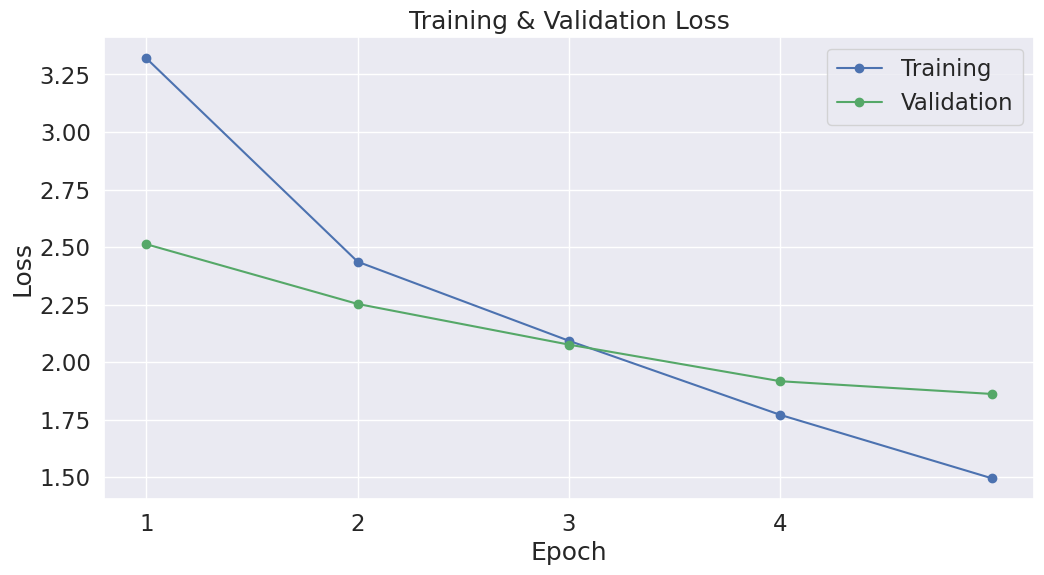

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50264, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model


In [4]:
output_dir = './model_save_new/'

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save_new/


('./model_save_new/tokenizer_config.json',
 './model_save_new/special_tokens_map.json',
 './model_save_new/vocab.json',
 './model_save_new/merges.txt',
 './model_save_new/added_tokens.json')

In [ ]:
# Added this to fix the next 3 commands
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding  # function is necessary
print(locale.getpreferredencoding())

UTF-8


In [ ]:
!ls -l --block-size=K ./model_save/

ls: cannot access './model_save/': No such file or directory


In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 475M Sep 11 06:06 ./model_save/pytorch_model.bin


In [15]:
model_dir = os.path.join(data_dir, 'model_save_new')
model_dir

"/content/gdrive/'My Drive'/'Cross Labs'/'Text Gen Models'/model_save_new"

In [16]:
!ls model_dir

ls: cannot access 'model_dir': No such file or directory


In [ ]:
# # Copy the model files to a directory in your Google Drive.
# !cp -r ./model_save_new/ $data_dir

# Generate Text

In [ ]:
# model_dir = '/content/gdrive/MyDrive/Cross Labs/Text Gen Models/model_save_new'
model_dir = './model_save_new'

# # Load a trained model and vocabulary that you have fine-tuned
model = GPT2LMHeadModel.from_pretrained(model_dir)
tokenizer = GPT2Tokenizer.from_pretrained(model_dir)


device = torch.device("cpu")  # USING CPU FOR NOW


model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50264, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50264, bias=False)
)

In [19]:
model.eval()

prompt = "<|startoftext|> [BODY-SCAN MEDITATION] Welcome to this body scan meditation script is designed for preparing you for sleep. Start by flexing and relaxing your"
# Welcome to this body scan meditation script is designed for preparing you for sleep. Start by flexing and relaxing your

# Encode the prompt to input into model
generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
input_tensor = generated.to(device)

sample_outputs = model.generate(
                                input_tensor,
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,
                                top_k=1000,
                                max_length = 300,
                                top_p=0.95,
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257, 50260, 14618,   284,   428,  1767,  9367, 16901,  4226,   318,
          3562,   329, 10629,   345,   329,  3993,    13,  7253,   416,  7059,
           278,   290, 28175,   534]])
0: Welcome to this body scan meditation script is designed for preparing you for sleep. Start by flexing and relaxing your feet. Stretch your legs up to reach your chest and allow them to open slightly. Prepare your body by taking a few deep breaths in. Stretch your arms and release them to your sides. Feel your entire body sinking down into the chair. Let your entire body relax. Feel the softness of your body. Your breathing is so easy, you can only hear me. Now let's bring awareness to your spine. Imagine you're walking through a forest, standing in beautiful ferns, this vast part of the forest is protected by a strong, strong, and strong tree. In order to get out of this tree, you need to ensure that there are two legs. The first is the green, and it's the longest it survives. The second i

These aren't bad at all!
